In [1]:
# Para conocer el enunciado del problema, consultar el libro:
# Metodos Numericos Aplicados a la Ingeniería: Casos de estudio utilizando MATLAB (2014)
# por Héctor Jorquera y Claudio Gelmi
# 
# Código Python escrito por Claudio Gelmi, Ph.D.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

In [3]:
# Datos exdataperimentales
xdata = np.array([0.1, 0.15, 0.25, 0.5, 0.75, 1.0, 1.5, 3.0])
mu = np.array([0.24, 0.27, 0.34, 0.35, 0.35, 0.34, 0.33, 0.22])

In [4]:
# CURVEFIT: ajuste no lineal de parámetros
def model_func(x, mu_max, km, kl):
    return mu_max*x/(km + x + kl*x**2)

initial_guess = [1.0, 1.0, 1.0]
params, pcov,_,mesg,_ = curve_fit(model_func, xdata=xdata, ydata=mu, p0=initial_guess, full_output=True)
print("- Mensaje de convergencia:", mesg)

# Cálculo de los intervalos de confianza
n = len(mu)  # cantidad de datos experimentales
p = len(params)  # cantidad de parámetros

# Grados de libertad
df = max(0, n - p)

# Intervalo y distribución t de acuerdo con un alpha.
alpha = 0.05
t_value = t.ppf(1 - alpha/2, df)  # valor de t para un alpha dado y según los grados de libertad

# Cálculo del error estándar y de los intervalos
perr = np.sqrt(np.diag(pcov))
ci = t_value*perr

print("- Resultados utilizando regresión no lineal (curve_fit):")
mu_max = params[0]
km = params[1]
kl = params[2]
print(f"mu_max = {mu_max:.3f} ± {ci[0]:.3f}")
print(f"km = {km:.3f} ± {ci[1]:.3f}")
print(f"kl = {kl:.3f} ± {ci[2]:.3f}")

# Cálculo del error cuadrático entre modelo y datos (sse)
mu_pred = model_func(xdata, *params)
sse = np.sum((mu - mu_pred)**2)
print(f"Error (SSE) = {round(sse,5)}")

- Mensaje de convergencia: Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
- Resultados utilizando regresión no lineal (curve_fit):
mu_max = 0.513 ± 0.101
km = 0.115 ± 0.059
kl = 0.390 ± 0.215
Error (SSE) = 0.00099


In [5]:
# Gráfico de 95% intervalos de confianza
x_range = xdata # Si queremos una curva suave: np.linspace(min(xdata), max(xdata), 400)
mu_pred = model_func(x_range, *params)

# Cálculo del Jacobiano para este problema
def jacobian(x, mu_max, km, kl):
    J = np.empty((len(x), len(params)))
    J[:, 0] = x/(km + x + kl * x**2)  # Derivada parcial con respecto a mu_max
    J[:, 1] = -(mu_max*x)/(km + x + kl*x**2)**2  # Derivada parcial con respecto a km
    J[:, 2] = -(mu_max*x**2)/(km + x + kl*x**2)**2  # Derivada parcial con respecto a kl
    return J

J = jacobian(x_range, *params)
sigma_mu = np.sqrt(np.sum((J @ pcov)*J, axis=1)) # Equivalente a np.sqrt(np.diag(J @pcov @ J.T)) pero + rápido
mu_upper = mu_pred + t_value*sigma_mu
mu_lower = mu_pred - t_value*sigma_mu

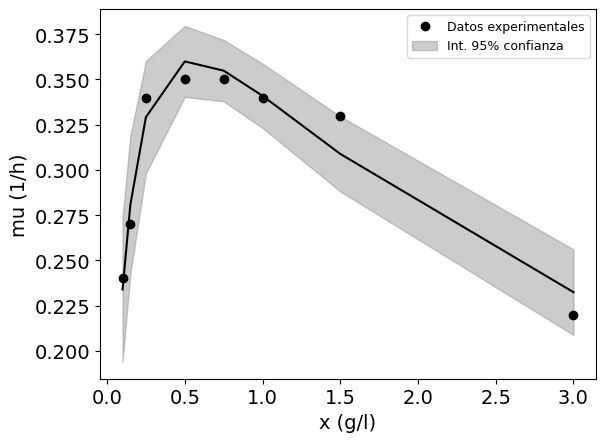

In [6]:
# Graficamos los resultados
plt.plot(xdata, mu, 'ko', label='Datos experimentales')
plt.plot(xdata, mu_pred, 'k-')
plt.xlabel('x (g/l)', fontsize=14)
plt.ylabel('mu (1/h)', fontsize=14)
plt.fill_between(x_range, mu_lower, mu_upper, color='gray', alpha=0.4, label='Int. 95% confianza')
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=9)

plt.show()